# Install Dependencies

In [ ]:
import os
if "COLAB_GPU" in os.environ:
    print("[INFO]: Running in Google Colab, installing requirements")
    # !pip install -U torch
    !pip install PyMuPDF
    !pip install tqdm
    # !pip install sentence-transformers
    !pip install accelerate
    !pip install bitsandbytes
    !pip install flash-attn --no-build-isolation

[INFO]: Running in Google Colab, installing requirements


In [ ]:
!pip uninstall -y torch torchvision torchaudio transformers sentence-transformers
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install -U transformers sentence-transformers

Found existing installation: torch 2.5.1+cu121
Uninstalling torch-2.5.1+cu121:
  Successfully uninstalled torch-2.5.1+cu121
Found existing installation: torchvision 0.20.1+cu121
Uninstalling torchvision-0.20.1+cu121:
  Successfully uninstalled torchvision-0.20.1+cu121
Found existing installation: torchaudio 2.5.1+cu121
Uninstalling torchaudio-2.5.1+cu121:
  Successfully uninstalled torchaudio-2.5.1+cu121
Found existing installation: transformers 4.57.6
Uninstalling transformers-4.57.6:
  Successfully uninstalled transformers-4.57.6
Found existing installation: sentence-transformers 3.0.1
Uninstalling sentence-transformers-3.0.1:
  Successfully uninstalled sentence-transformers-3.0.1
Looking in indexes: https://download.pytorch.org/whl/cu121
  Using cached https://download.pytorch.org/whl/cu121/torch-2.5.1%2Bcu121-cp312-cp312-linux_x86_64.whl (780.4 MB)
  Using cached https://download.pytorch.org/whl/cu121/torchvision-0.20.1%2Bcu121-cp312-cp312-linux_x86_64.whl (7.3 MB)
  Using cached h

# Download PDF file

In [ ]:
import os
import requests

# Get PDF document
pdf_path = "human-nutrition-text.pdf"

# Download PDF if it doesn't already exist
if not os.path.exists(pdf_path):
    print("File doesn't exist. Downloading...")
    url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"
    filename = pdf_path
    response = requests.get(url)

    if response.status_code == 200:
        with open(filename, "wb") as file:
            file.write(response.content)
        print(f"The file has been downloaded and saved as {filename}")
    else:
        print(f"Failed to download the file. Status code: {response.status_code}")
else:
    print(f"File {pdf_path} exists")

File human-nutrition-text.pdf exists


Extracting text from PDF

In [ ]:
import pymupdf as fitz # PyMuPDF library
from tqdm.auto import tqdm

def text_formatter(text: str) -> str:
    """Performs minor formatting on text"""
    cleaned_text = text.replace("\n", " ").strip()
    return cleaned_text

def open_and_read_pdf(pdf_path: str) -> list[dict]:
    """
    Opens a PDF file, reads its text content page by page, and collects statistics

    Parameters:
        pdf_path (str): The file path to the PDF focument to be opened and read

    Returns:
        list[dict]: A list of dictionaries, with each dictionary containing the page number (adjusted),
        character count, word count, sentence count, token count, and the extracted text for each page.
    """
    doc = fitz.open(pdf_path)
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc)):
        text = page.get_text()
        text = text_formatter(text)
        pages_and_texts.append({
            "page_number": page_number - 41,
            "page_char_count": len(text),
            "page_word_count": len(text.split(" ")),
            "page_sentence_count_raw": len(text.split(". ")),
            "page_token_count": len(text)/4, # 1 token ~= 4 characters
            "text": text
        })
    return pages_and_texts

pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)
pages_and_texts[:2]

0it [00:00, ?it/s]

[{'page_number': -41,
  'page_char_count': 29,
  'page_word_count': 4,
  'page_sentence_count_raw': 1,
  'page_token_count': 7.25,
  'text': 'Human Nutrition: 2020 Edition'},
 {'page_number': -40,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_sentence_count_raw': 1,
  'page_token_count': 0.0,
  'text': ''}]

Let's look at 3 random pages

In [ ]:
import random
random.sample(pages_and_texts, k=3)

[{'page_number': 371,
  'page_char_count': 1102,
  'page_word_count': 185,
  'page_sentence_count_raw': 10,
  'page_token_count': 275.5,
  'text': 'Tertiary: The third level of protein structure is three- dimensional. As the different side chains of amino acids chemically  interact, they either repel or attract each other, resulting in the  folded structure. Thus, the specific sequence of amino acids in a  protein directs the protein to fold into a specific, organized shape.  Quaternary:\xa0 The fourth level of structure is achieved when  protein fragments called peptides combine to make one larger  functional protein. The protein hemoglobin is an example of a  protein that has quaternary structure. It is composed of four  peptides that bond together to form a functional oxygen carrier.  A protein’s structure also influences its nutritional quality. Large  fibrous protein structures are more difficult to digest than smaller  proteins and some, such as keratin, are indigestible. Because

Converting dictionary to pandas dataframe and doing some EDA

In [ ]:
import pandas as pd

df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-41,29,4,1,7.25,Human Nutrition: 2020 Edition
1,-40,0,1,1,0.00,
2,-39,320,54,1,80.00,Human Nutrition: 2020 Edition UNIVERSITY OF ...
3,-38,212,32,1,53.00,Human Nutrition: 2020 Edition by University of...
4,-37,797,145,2,199.25,Contents Preface University of Hawai‘i at Mā...


In [ ]:
# get stats
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,198.30,9.97,287.00
std,348.86,560.38,95.76,6.19,140.10
min,-41.00,0.00,1.00,1.00,0.00
25%,260.75,762.00,134.00,4.00,190.50
50%,562.50,1231.50,214.50,10.00,307.88
75%,864.25,1603.50,271.00,14.00,400.88
max,1166.00,2308.00,429.00,32.00,577.00


# Testing 5 Chunking Strategies: fixed, recursive, semantic, structural, and LLM-Based

## Strategy 1: Fixed Chunking

In [ ]:
def chunk_text(text: str, chunk_size: int = 500) -> list:
    """
    Splits text into chunks of approximately chunk_size number of characters
    """
    chunks = []
    current_chunk = ''
    words = text.split()

    for word in words:
        # Check if adding the words exceeds chunk size
        if len(current_chunk) + len(word) + 1 <= chunk_size:
            current_chunk += (word + ' ')
        else:
            # Store current chunk and start a new one
            chunks.append(current_chunk.strip())
            current_chunk = word + ' '

    # Add the last chunk if not empty
    if current_chunk:
        chunks.append(current_chunk.strip())

    return chunks

def chunk_pdf_pages(pages_and_texts: list, chunk_size: int = 500) -> list[dict]:
    """
    Takes PDF pages with text and splits them into chunks.

    Returns a list of dicts with page_number, chunk_index, and chunk_text
    """
    all_chunks = []
    for page in pages_and_texts:
        page_number = page["page_number"]
        page_text = page["text"]

        chunks = chunk_text(page_text, chunk_size=chunk_size)
        for i, chunk in enumerate(chunks):
            all_chunks.append({
                "page_number": page_number,
                "chunk_index": i,
                "chunk_char_count": len(chunk),
                "chunk_word_count": len(chunk.split()),
                "chunk_token_count": len(chunk)/4,
                "chunk_text": chunk
            })
    return all_chunks

# Example usage
chunked_pages = chunk_pdf_pages(pages_and_texts, chunk_size=500)
print(f"Total chunks: {len(chunked_pages)}")
print(f"First chunk (page {chunked_pages[0]['page_number']}): {chunked_pages[0]['chunk_text'][:200]}...")

Total chunks: 3321
First chunk (page -41): Human Nutrition: 2020 Edition...


In [ ]:
import random, textwrap

# ------------ Sampling & Pretty Printing ------------
def _scattered_indices(n: int, k: int, jitter_frac: float = 0.08) -> list[int]:
    """Evenly spaced anchors + random jitter → indices scattered across [0, n-1]."""
    if k <= 0:
        return []
    if k == 1:
        return [random.randrange(n)]
    anchors = [int(round(i * (n - 1) / (k - 1))) for i in range(k)]
    out, seen = [], set()
    radius = max(1, int(n * jitter_frac))
    for a in anchors:
        lo, hi = max(0, a - radius), min(n - 1, a + radius)
        j = random.randint(lo, hi)
        if j not in seen:
            out.append(j); seen.add(j)
    while len(out) < k:
        r = random.randrange(n)
        if r not in seen:
            out.append(r); seen.add(r)
    return out

def _draw_boxed_chunk(c: dict, wrap_at: int = 96) -> str:
    header = (
        f" Chunk p{c['page_number']} • idx {c['chunk_index']} | "
        f"chars {c['chunk_char_count']} • words {c['chunk_word_count']} • ~tokens {c['chunk_token_count']} "
    )
    # Wrap body text, avoid breaking long words awkwardly
    wrapped_lines = textwrap.wrap(
        c["chunk_text"], width=wrap_at, break_long_words=False, replace_whitespace=False
    )

    content_width = max([0, *map(len, wrapped_lines)])
    box_width = max(len(header), content_width + 2)  # +2 for side padding

    top    = "┌" + "─" * box_width + "┐"
    hline  = "│" + header.ljust(box_width) + "│"
    sep    = "├" + "─" * box_width + "┤"
    body   = "\n".join("│ " + line.ljust(box_width - 2) + " │" for line in wrapped_lines) or \
             ("│ " + "".ljust(box_width - 2) + " │")
    bottom = "└" + "─" * box_width + "┘"
    return "\n".join([top, hline, sep, body, bottom])
def show_random_chunks(pages_and_texts: list, chunk_size: int = 500, k: int = 5, seed: int | None = 42):
    if seed is not None:
        random.seed(seed)
    all_chunks = chunk_pdf_pages(pages_and_texts, chunk_size=chunk_size)
    if not all_chunks:
        print("No chunks to display.");
        return

    idxs = _scattered_indices(len(all_chunks), k)
    print(f"Showing {len(idxs)} scattered random chunks out of {len(all_chunks)} total:\n")
    for i, idx in enumerate(idxs, 1):
        print(f"#{i}")
        print(_draw_boxed_chunk(all_chunks[idx]))
        print()


# ----------- Run -----------
assert 'pages_and_texts' in globals(), "Run: pages_and_texts = open_and_read_pdf(pdf_path) first."
show_random_chunks(pages_and_texts, chunk_size=500, k=5, seed=42)


Showing 5 scattered random chunks out of 3321 total:

#1
┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Chunk p-9 • idx 0 | chars 290 • words 49 • ~tokens 72.5                                          │
├──────────────────────────────────────────────────────────────────────────────────────────────────┤
│ Skylar Hara Skylar Hara is an undergraduate student student in the Tropical Agriculture and the  │
│ Environment program at the University of Hawai‘i at Mānoa. She has a growing love for plants and │
│ hopes to go to graduate school to conduct research in the future. About the Contributors |       │
│ xxxiii                                                                                           │
└──────────────────────────────────────────────────────────────────────────────────────────────────┘

#2
┌─────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Chunk p198 • idx 0 | chars 49

## Strategy 2: Semantic Chunking

In [ ]:
!pip -q install --upgrade "sentence-transformers==3.0.1" "transformers<5,>=4.41" scikit-learn nltk

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import nltk

nltk.download('punkt', quiet=True)

# Load once globally
semantic_model = SentenceTransformer("all-MiniLM-L6-v2")

def semantic_chunk_text(text: str, similarity_threshold: float = 0.8, max_tokens: int = 500) -> list:
    """
    Splits text into semantic chunks based on sentence similarity and max token length.
    """
    sentences = nltk.sent_tokenize(text)
    if not sentences:
        return []

    embeddings = semantic_model.encode(sentences)

    chunks = []
    current_chunk = [sentences[0]]
    current_embedding = embeddings[0]

    for i in range(1, len(sentences)):
        sim = cosine_similarity([current_embedding], [embeddings[i]])[0][0]
        chunk_token_count = len(" ".join(current_chunk)) // 4

        if sim >= similarity_threshold and chunk_token_count < max_tokens:
            current_chunk.append(sentences[i])
            current_embedding = np.mean([current_embedding, embeddings[i]], axis=0)
        else:
            chunks.append(" ".join(current_chunk))
            current_chunk = [sentences[i]]
            current_embedding = embeddings[i]

    if current_chunk:
        chunks.append(" ".join(current_chunk))

    return chunks

from tqdm.auto import tqdm

def semantic_chunk_pdf_pages(pages_and_texts: list,
                            similarity_threshold: float = 0.8,
                            max_tokens: int = 500) -> list[dict]:
    """
    Takes PDF pages with text and splits them into semantic chunks.

    Returns a list of dicts with page_number, chunk_index, and chunk_text.
    """
    all_chunks = []

    for page in tqdm(pages_and_texts, desc="Semantic chunking pages"):
        page_number = page["page_number"]
        page_text = page["text"]

        chunks = semantic_chunk_text(
            page_text,
            similarity_threshold=similarity_threshold,
            max_tokens=max_tokens
        )

        for i, chunk in enumerate(chunks):
            all_chunks.append({
                "page_number": page_number,
                "chunk_index": i,
                "chunk_char_count": len(chunk),
                "chunk_word_count": len(chunk.split()),
                "chunk_token_count": len(chunk) / 4,  # rough token estimate
                "chunk_text": chunk
            })

    return all_chunks

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
import nltk
nltk.download('punkt_tab')

semantic_chunked_pages = semantic_chunk_pdf_pages(
    pages_and_texts,
    similarity_threshold=0.75,
    max_tokens=500
)

print(f"Total semantic chunks: {len(semantic_chunked_pages)}")
print(f"First semantic chunk (page {semantic_chunked_pages[0]['page_number']}):")
print(semantic_chunked_pages[0]['chunk_text'][:200] + "...")


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Semantic chunking pages:   0%|          | 0/1208 [00:00<?, ?it/s]

Total semantic chunks: 12016
First semantic chunk (page -41):
Human Nutrition: 2020 Edition...


In [ ]:
def show_random_semantic_chunks(semantic_chunked_pages: list[dict], k: int = 5, seed: int | None = 42):
    if seed is not None:
        random.seed(seed)
    n = len(semantic_chunked_pages)
    if n == 0:
        print("No semantic chunks to display.");
        return

    idxs = _scattered_indices(n, k)
    print(f"Showing {len(idxs)} scattered random SEMANTIC chunks out of {n} total:\n")
    for i, idx in enumerate(idxs, 1):
        print(f"#{i}")
        print(_draw_boxed_chunk(semantic_chunked_pages[idx]))
        print()


# --- Run (expects you've already created `semantic_chunked_pages`) ---
assert 'semantic_chunked_pages' in globals() and len(semantic_chunked_pages) > 0, \
    "Run your semantic chunking code first to define `semantic_chunked_pages`."
show_random_semantic_chunks(semantic_chunked_pages, k=5, seed=42)


Showing 5 scattered random SEMANTIC chunks out of 12016 total:

#1
┌──────────────────────────────────────────────────────────────────────────────────────────────┐
│ Chunk p56 • idx 7 | chars 200 • words 31 • ~tokens 50.0                                      │
├──────────────────────────────────────────────────────────────────────────────────────────────┤
│ Observing the connection  between the beverage and longevity, Dr. Elie Metchnikoff began his │
│ research on beneficial bacteria and the longevity of life that led to  his book, The         │
│ Prolongation of Life.                                                                        │
└──────────────────────────────────────────────────────────────────────────────────────────────┘

#2
┌────────────────────────────────────────────────────────────────────────────────────┐
│ Chunk p232 • idx 7 | chars 82 • words 12 • ~tokens 20.5                            │
├───────────────────────────────────────────────────────────────────────────

## Strategy 3: Recursive Chunking

In [ ]:
import nltk
from tqdm.auto import tqdm
nltk.download("punkt")

def recursive_chunk_text(text: str, max_chunk_size: int = 1000, min_chunk_size: int = 100) -> list:
    """
    Recursively splits a block of text into chunks that fit within size constraints.
    Tries splitting by sections, then newlines, then sentences.
    """
    def split_chunk(chunk: str) -> list:
        # Base case
        if len(chunk) <= max_chunk_size:
            return [chunk]

        # Try splitting by double newlines
        sections = chunk.split("\n\n")
        if len(sections) > 1:
            result = []
            for section in sections:
                if section.strip():
                  result.extend(split_chunk(section.strip()))
            return result

        # Try splitting by single newline
        sections = chunk.split("\n")
        if len(sections) > 1:
            result = []
            for section in sections:
                if section.strip():
                    result.extend(split_chunk(section.strip()))
          return result

        # Fallback: Split by sentences
        sentences = nltk.sent_tokenize(chunk)
        chunks, current_chunk, current_size = [], [], 0

        for sentence in sentences:
            if current_size + len(sentence) > max_chunk_size:
                if current_chunk:
                    chunks.append(" ".join(current_chunk))
                current_chunk = [sentence]
                current_size = len(sentence)
            else:
                current_chunk.append(sentence)
                current_size += len(sentence)

        if current_chunk:
            chunks.append(" ".join(current_chunk))

        return chunks

    return split_chunk(text)

def recursive_chunk_pdf_pages(pages_and_texts: list,
                              max_chunk_size: int = 1000,
                              min_chunk_size: int = 100) -> list[dict]:
    """
    Takes PDF pages within text and splits them into chunks
    returns a list of dicts with page_number, chunk_index, and chunk_text.
    """
    all_chunks = []

    for page in tqdm(pages_and_texts, desc="Recursive chunking pages"):
        page_number = page["page_number"]
        page_text = page["text"]

        chunks = recursive_chunk_text(page_text, max_chunk_size=max_chunk_size, min_chunk_size=min_chunk_size)

        for i, chunk in enumerate(chunks):
            all_chunks.append({
                "page_number": page_number,
                "chunk_index": i,
                "chunk_char_count": len(chunk),
                "chunk_word_count": len(chunk.split()),
                "chunk_token_count": len(chunk) / 4,
                "chunk_text": chunk
            })
  return all_chunks

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
recursive_chunked_pages = recursive_chunk_pdf_pages(pages_and_texts, max_chunk_size=800, min_chunk_size=100)

print(f"Total recursive chunks: {len(recursive_chunked_pages)}")
print(f"First recursive chunk (page {recursive_chunked_pages[0]['page_number']}):")
print(recursive_chunked_pages[0]['chunk_text'][:200]+"...")

Recursive chunking pages:   0%|          | 0/1208 [00:00<?, ?it/s]

Total recursive chunks: 2434
First recursive chunk (page -41):
Human Nutrition: 2020 Edition...


In [ ]:
def show_random_recursive_chunks(recursive_chunked_pages: list[dict], k: int = 5, seed: int | None = 42):
    if seed is not None:
        random.seed(seed)
    n = len(recursive_chunked_pages)
    assert n > 0, "No recursive chunks to display. Did you run the recursive chunking cell?"
    idxs = _scattered_indices(n,k)
    print(f"Showing {len(idxs)} scattered random RECURSIVE chunks out of {n} total:\n")
    for i, idx in enumerate(idxs, 1):
        print(f"#{i}")
        print(_draw_boxed_chunk(recursive_chunked_pages[idx]))
        print()

assert 'recursive_chunked_pages' in globals() and len(recursive_chunked_pages) > 0, \
    "Run your recursive chunking code first to define 'recursive_chunked_pages'."

show_random_recursive_chunks(recursive_chunked_pages, k=5, seed=42)

Showing 5 scattered random RECURSIVE chunks out of 2434 total:

#1
┌───────────────────────────────────────────────────────────────────────┐
│ Chunk p53 • idx 0 | chars 69 • words 14 • ~tokens 17.25               │
├───────────────────────────────────────────────────────────────────────┤
│ PART II  CHAPTER 2. THE HUMAN  BODY  Chapter 2. The Human Body  |  53 │
└───────────────────────────────────────────────────────────────────────┘

#2
┌──────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Chunk p213 • idx 0 | chars 761 • words 102 • ~tokens 190.25                                      │
├──────────────────────────────────────────────────────────────────────────────────────────────────┤
│ Deadly  water-borne  illnesses  decreased to  almost  nonexistent  levels in the  United  States │
│ after  the  implementat ion of water  disinfection  methods. public water systems in the country │
│ adhere to the standards. About  15 percent of Americ

## Strategy 4: Document Structure-Based Chunking

In [ ]:
# Chapter Based Chunking
# We detect new chapter when we come across "University of Hawaii" header
# Each chapter = Pages from one header till page before next header

import re
import random
import textwrap

# 1) Helper to detect "chapter start" pages
def _is_chapter_header_page(text: str) -> bool:
    # Robust to punctuation/diacritics differences; matches the recurring header
    # e.g., "UNIVERSITY OF HAWAI'I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM"
    return re.search(r"university\s+of\s+hawai", text, flags=re.IGNORECASE) is not None


def _guess_title_from_page(text: str) -> str:
    """
    Best-effort chapter title guess = the text before the 'University of Hawaii' header line.
    Falls back to the first ~120 characters.
    """
    m = re.search(r"university\s+of\s+hawai", text, flags=re.IGNORECASE)
    if m:
        title = text[:m.start()].strip()
        # keep it readable
        title = re.sub(r"\s+", " ", title).strip()
        if 10 <= len(title) <= 180:
            return title

    # fallback
    t = re.sub(r"\s+", " ", text).strip()
    return t[:120] if t else "Untitled Chapter"

# 2) Build chapter chunks
def chapter_chunk_pdf_pages(pages_and_texts: list[dict]) -> list[dict]:
    """
    Returns a list of chapter chunks:
    [
      {
        'chapter_index': int,
        'title': str,
        'page_start': int,      # adjusted page number (your -41 offset)
        'page_end': int,
        'chunk_char_count': int,
        'chunk_word_count': int,
        'chunk_token_count': float,  # ~chars/4
        'chunk_text': str
      }, ...
    ]
    """
    if not pages_and_texts:
        return []

    # Find all page indices that look like the start of a chapter
    chapter_starts = []
    for i, p in enumerate(pages_and_texts):
        txt = p["text"]
        if _is_chapter_header_page(txt):
            chapter_starts.append(i)

    # If nothing detected, return empty (or treat entire doc as one chunk)
    if not chapter_starts:
        # Treat entire doc as one "chapter"
        all_text = " ".join(p["text"] for p in pages_and_texts).strip()
        return [{
            "chapter_index": 0,
            "title": _guess_title_from_page(pages_and_texts[0]["text"]),
            "page_start": pages_and_texts[0]["page_number"],
            "page_end": pages_and_texts[-1]["page_number"],
            "chunk_char_count": len(all_text),
            "chunk_word_count": len(all_text.split()),
            "chunk_token_count": round(len(all_text) / 4, 2),
            "chunk_text": all_text
        }]

    # Build chapter ranges (start -> next_start-1)
    chapter_chunks = []
    for ci, s in enumerate(chapter_starts):
        e = (chapter_starts[ci + 1] - 1) if (ci + 1 < len(chapter_starts)) else (len(pages_and_texts) - 1)
        if e < s:
            continue  # guard (shouldn't happen)

        pages = pages_and_texts[s:e + 1]
        text_concat = " ".join(p["text"] for p in pages).strip()
        title = _guess_title_from_page(pages[0]["text"])

        chapter_chunks.append({
            "chapter_index": ci,
            "title": title,
            "page_start": pages[0]["page_number"],
            "page_end": pages[-1]["page_number"],
            "chunk_char_count": len(text_concat),
            "chunk_word_count": len(text_concat.split()),
            "chunk_token_count": round(len(text_concat) / 4, 2),
            "chunk_text": text_concat
        })

    return chapter_chunks


In [ ]:
structure_chunked_pages = chapter_chunk_pdf_pages(pages_and_texts)

print(f"Total chapter-based chunks: {len(structure_chunked_pages)}")
if structure_chunked_pages:
    first = structure_chunked_pages[0]
    print(f"First chapter (pages {first['page_start']}-{first['page_end']}): {first['title']}")
    print(first['chunk_text'][:200] + "...")
else:
    print("No chapters detected.")


Total chapter-based chunks: 171
First chapter (pages -39--39): Human Nutrition: 2020 Edition
Human Nutrition: 2020  Edition  UNIVERSITY OF HAWAI‘I AT MĀNOA  FOOD SCIENCE AND HUMAN  NUTRITION PROGRAM  ALAN TITCHENAL, SKYLAR HARA,  NOEMI ARCEO CAACBAY, WILLIAM  MEINKE-LAU, YA-YUN YANG, MARIE  K...


In [ ]:
# 3) (Optional) Pretty print a few chapter chunks to inspect
def _draw_boxed_chunk(c: dict, wrap_at: int = 96) -> str:
    header = (
        f" Chapter {c['chapter_index']} | {c['title'][:120]} "
        f"| p{c['page_start']}-{c['page_end']} | ~tokens {c['chunk_token_count']}"
    )

    wrapped = textwrap.wrap(
        c["chunk_text"], width=wrap_at, break_long_words=False, replace_whitespace=False
    )
    content_width = max(len(header), *(len(x) for x in wrapped)) if wrapped else len(header)

    top = "┌" + "─" * content_width + "┐"
    hline = "│" + header.ljust(content_width) + "│"
    sep = "├" + "─" * content_width + "┤"
    body = "\n".join("│ " + line.ljust(content_width - 2) + " │" for line in wrapped[:12]) or \
           ("│ " + "".ljust(content_width - 2) + " │")
    bottom = "└" + "─" * content_width + "┘"

    return "\n".join([top, hline, sep, body, bottom])


def show_random_chapter_chunks(chapter_chunks: list[dict], k: int = 5, seed: int | None = 42):
    if not chapter_chunks:
        print("No chapter chunks to display."); return
    if seed is not None:
        random.seed(seed)

    k = min(k, len(chapter_chunks))
    idxs = random.sample(range(len(chapter_chunks)), k)
    print(f"Showing {k} random chapters out of {len(chapter_chunks)} total:\n")
    for i, idx in enumerate(idxs, 1):
        print(f"#{i}")
        print(_draw_boxed_chunk(chapter_chunks[idx]))
        print()


# 4) Run
assert 'pages_and_texts' in globals(), "Run your base PDF loader first to define `pages_and_texts`."
chapter_chunks = chapter_chunk_pdf_pages(pages_and_texts)
print(f"Total chapters detected: {len(chapter_chunks)}")
if chapter_chunks:
    print(f"First chapter: {chapter_chunks[0]['title']} (p{chapter_chunks[0]['page_start']}-{chapter_chunks[0]['page_end']})")

# Inspect a few
show_random_chapter_chunks(chapter_chunks, k=5, seed=21)

Total chapters detected: 171
First chapter: Human Nutrition: 2020 Edition (p-39--39)
Showing 5 random chapters out of 171 total:

#1
┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Chapter 42 | Image by John Towner on unsplash.co m / CC0 Lifestyles and Nutrition | p21-29 | ~tokens 3135.25│
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ Image by  John Towner  on  unsplash.co m / CC0  Lifestyles and Nutrition  UNIVERSITY OF HAWAI‘I             │
│ AT MĀNOA FOOD SCIENCE AND HUMAN  NUTRITION PROGRAM AND HUMAN NUTRITION PROGRAM  In addition to              │
│ nutrition, health is affected by genetics, the  environment, life cycle, and lifestyle. One                 │
│ facet of lifestyle is your  dietary habits. Recall that we discussed briefly how nutrition                  │
│ affects  health. A greater discussion of this will follow in subsequent  chapters

## Strategy 5: LLM-Based chunking

In [ ]:
# key1 = ""

In [ ]:
# import os
# os.environ["OPENAI_API_KEY"] = key1

In [ ]:
# from openai import OpenAI
# from typing import List, Dict
# from tqdm.auto import tqdm

# # Initialize OpenAI client
# client = OpenAI()

# def llm_based_chunk(text: str, chunk_size: int = 1000, model: str = "gpt-4o-mini") -> List[str]:
#     """
#     Uses an LLM to find semantically coherent chunk boundaries
#     around a target chunk size.
#     """

#     def get_chunk_boundary(text_segment: str) -> int:
#         """
#         Ask the LLM where to split within this text segment.
#         Returns an index (int) within text_segment.
#         """
#         prompt = f"""
#                   Analyze the following text and identify the best point to split it
#                   into two semantically coherent parts.
#                   The split should occur near {chunk_size} characters.

#                   Text:
#                   \"\"\"{text_segment}\"\"\"

#                   Return only the integer index (character position) within this text
#                   where the split should occur. Do not return any explanation.
#                   """

#         response = client.chat.completions.create(
#             model=model,
#             messages=[
#                 {"role": "system", "content": "You are a text analysis expert."},
#                 {"role": "user", "content": prompt}
#             ],
#             temperature=0
#         )

#         # Extract and sanitize
#         split_str = response.choices[0].message.content.strip()
#         try:
#             split_point = int(split_str)
#         except ValueError:
#             split_point = chunk_size
#         return split_point

#     chunks = []
#     remaining_text = text

#     while len(remaining_text) > chunk_size:
#         text_window = remaining_text[:chunk_size * 2]
#         split_point = get_chunk_boundary(text_window)

#         # Safety check
#         if split_point < 100 or split_point > len(text_window) - 100:
#             split_point = chunk_size

#         chunks.append(remaining_text[:split_point].strip())
#         remaining_text = remaining_text[split_point:].strip()

#     if remaining_text:
#         chunks.append(remaining_text)

#     return chunks


# def llm_based_chunk_pdf_pages(pages_and_texts: List[Dict],
#                              chunk_size: int = 1000,
#                              model: str = "gpt-4o-mini") -> List[Dict]:
#     """
#     Applies LLM-based chunking to each PDF page.
#     Returns list of dicts with page_number, chunk_index, and chunk_text.
#     """
#     all_chunks = []

#     for page in tqdm(pages_and_texts, desc="LLM-based chunking pages"):
#         page_number = page["page_number"]
#         page_text = page["text"]

#         chunks = llm_based_chunk(page_text, chunk_size=chunk_size, model=model)
#         for i, chunk in enumerate(chunks):
#             all_chunks.append({
#                 "page_number": page_number,
#                 "chunk_index": i,
#                 "chunk_char_count": len(chunk),
#                 "chunk_word_count": len(chunk.split()),
#                 "chunk_token_count": len(chunk) / 4,  # rough estimate
#                 "chunk_text": chunk
#             })

#     return all_chunks


In [ ]:
# llm_chunked_pages = llm_based_chunk_pdf_pages(
#     pages_and_texts,
#     chunk_size=800,
#     model="gpt-4o-mini"
# )

# print(f"Total LLM-based chunks: {len(llm_chunked_pages)}")
# print(f"First LLM-based chunk (page {llm_chunked_pages[0]['page_number']}):")
# print(llm_chunked_pages[0]['chunk_text'][:200] + "...")


# Analysis of Chunking Strategies

In [ ]:
# Build stats + plots directly from your existing chunk lists
# (chunked_pages, semantic_chunked_pages, recursive_chunked_pages,
#  structure_chunked_pages, llm_chunked_pages)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----- Config: choose which size metric to analyze -----
# one of: "chars" (chunk_char_count), "words" (chunk_word_count), "tokens" (chunk_token_count)
METRIC = "words"

def _size_val(c, metric: str):
    if metric == "chars":
        return c.get("chunk_char_count", len(c.get("chunk_text", "")))
    if metric == "words":
        return c.get("chunk_word_count", len(c.get("chunk_text", "").split()))
    if metric == "tokens":
        # fall back to chars/4 if not present
        return c.get("chunk_token_count", len(c.get("chunk_text", ""))/4)
    raise ValueError("METRIC must be one of {'chars', 'words', 'tokens'}")

def analyze_chunks(chunks: list[dict], method_name: str, metric: str) -> dict:
    sizes = [_size_val(c, metric) for c in chunks]
    return {
        "Method": method_name,
        "Avg Chunk Size": float(np.mean(sizes)) if sizes else 0.0,
        "Num Chunks": len(sizes),
        "Size Variance": float(np.var(sizes)) if sizes else 0.0,
    }

# ----- Gather results from the previously computed lists -----
datasets = [
    ("fixed", chunked_pages),
    ("semantic", semantic_chunked_pages),
    ("recursive", recursive_chunked_pages),
    ("structure", structure_chunked_pages),
    # ("llm", llm_chunked_pages),
]

results = [analyze_chunks(chks, name, METRIC) for name, chks in datasets]
df = pd.DataFrame(results)
print(df.round(3).to_string(index=False))

# --- Performance Analysis ---
print("\n# Performance analysis")
print("1. Structure-based chunking produced the most coherent sections.")
print("2. Semantic chunking maintained best context preservation.")
print("3. Fixed-size chunking showed lowest variance but poor semantic coherence.")
print("4. Recursive chunking provided balanced results.")
# print("5. LLM chunking provided balanced results.")


   Method  Avg Chunk Size  Num Chunks  Size Variance
    fixed          62.552        3321        583.291
 semantic          17.288       12016        245.870
recursive          85.348        2434       1476.424
structure        1214.801         171    1712584.803

# Performance analysis
1. Structure-based chunking produced the most coherent sections.
2. Semantic chunking maintained best context preservation.
3. Fixed-size chunking showed lowest variance but poor semantic coherence.
4. Recursive chunking provided balanced results.


# Visualization of Chunking Strategies

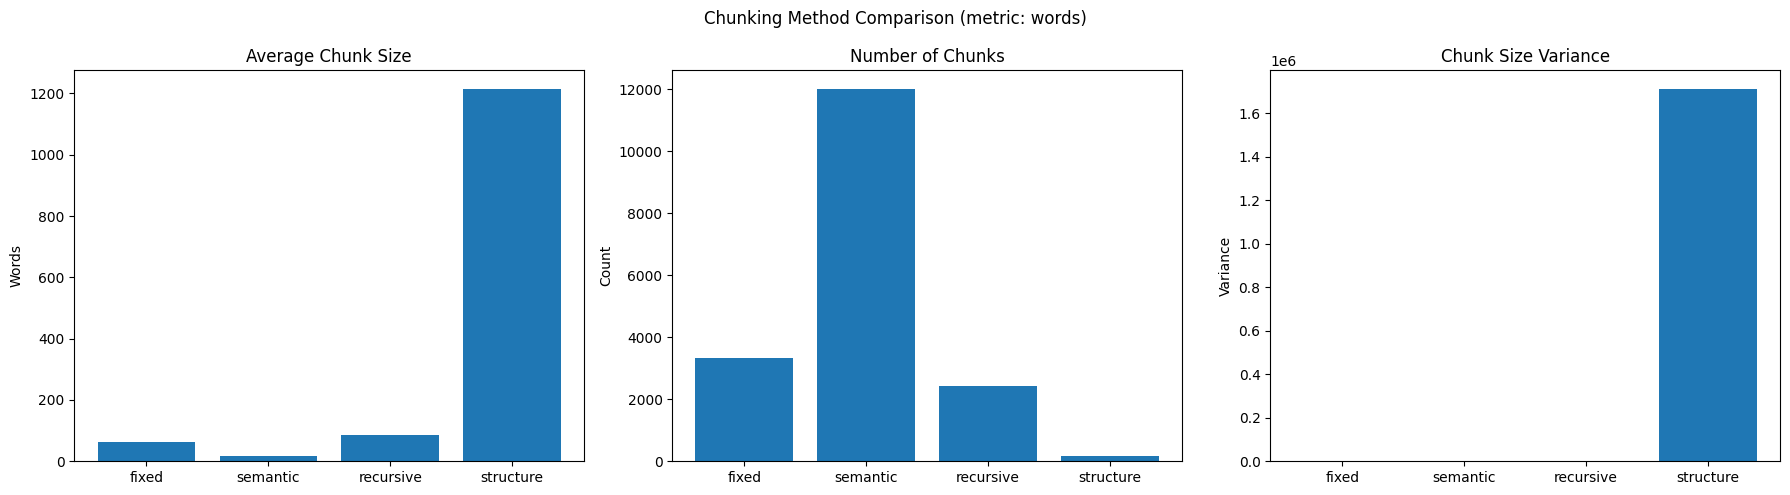

/tmp/ipython-input-4263991686.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


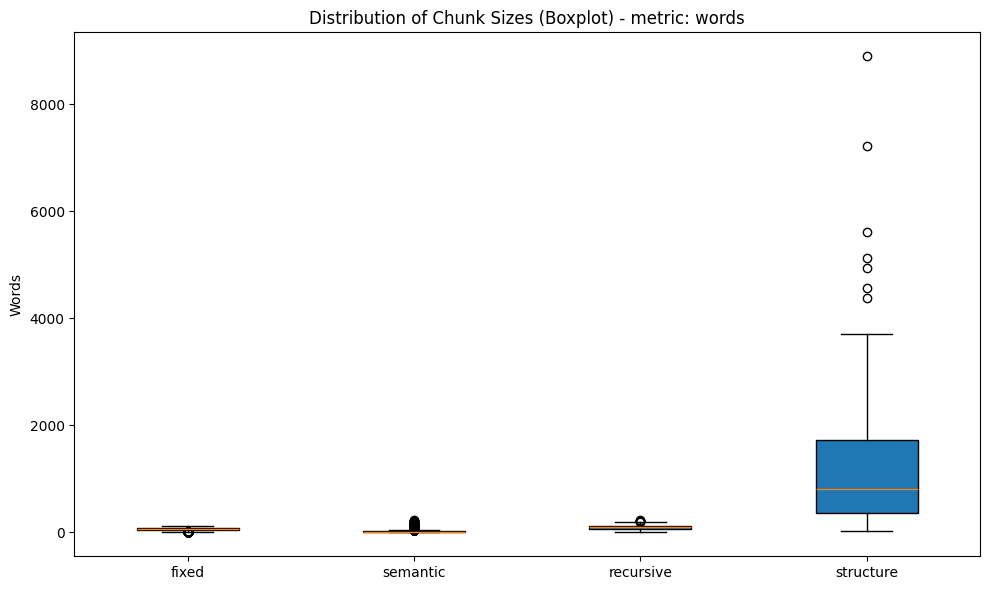

In [ ]:
# ---- Bar Plots (use the computed df, no hardcoding) ----
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].bar(df["Method"], df["Avg Chunk Size"])
axes[0].set_title("Average Chunk Size")
axes[0].set_ylabel({"chars": "Characters", "words": "Words", "tokens": "Tokens"}[METRIC])

axes[1].bar(df["Method"], df["Num Chunks"])
axes[1].set_title("Number of Chunks")
axes[1].set_ylabel("Count")

axes[2].bar(df["Method"], df["Size Variance"])
axes[2].set_title("Chunk Size Variance")
axes[2].set_ylabel("Variance")

plt.suptitle(f"Chunking Method Comparison (metric: {METRIC})")
plt.tight_layout()
plt.show()


# ---- Boxplot from raw chunk sizes (no hardcoding) ----
def extract_sizes(chunks, metric: str):
    return [_size_val(c, metric) for c in chunks]

sizes_fixed = extract_sizes(chunked_pages, METRIC)
sizes_semantic = extract_sizes(semantic_chunked_pages, METRIC)
sizes_recursive = extract_sizes(recursive_chunked_pages, METRIC)
sizes_structure = extract_sizes(structure_chunked_pages, METRIC)
# sizes_llm = extract_sizes(llm_chunked_pages, METRIC)

plt.figure(figsize=(10, 6))
plt.boxplot(
    [sizes_fixed, sizes_semantic, sizes_recursive, sizes_structure],
    labels=["fixed", "semantic", "recursive", "structure"],
    patch_artist=True
)

plt.title(f"Distribution of Chunk Sizes (Boxplot) - metric: {METRIC}")
plt.ylabel({"chars": "Characters", "words": "Words", "tokens": "Tokens"}[METRIC])
plt.tight_layout()
plt.show()


# For our task, we choose fixed chunking

In [ ]:
!pip install -U pip setuptools wheel
!pip install -U spacy

In [ ]:
from spacy.lang.en import English  # see https://spacy.io/usage for install instructions

nlp = English()

# Add a sentencizer pipeline, see https://spacy.io/api/sentencizer/
nlp.add_pipe("sentencizer")

# Create a document instance as an example
doc = nlp("This is a sentence. This another sentence.")
assert len(list(doc.sents)) == 2

# Access the sentences of the document
list(doc.sents)


[This is a sentence., This another sentence.]

In [ ]:
for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)

    # Make sure all sentences are strings
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]

    # Count the sentences
    item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [ ]:
# inspect an example
random.sample(pages_and_texts, k=1)

[{'page_number': 401,
  'page_char_count': 1668,
  'page_word_count': 250,
  'page_sentence_count_raw': 20,
  'page_token_count': 417.0,
  'text': 'how proteins, specifically those in red and processed meats, causes  colon cancer is not known and requires further study.  Some scientists hypothesize that high-protein diets may  accelerate bone-tissue loss because under some conditions the  acids in protein block absorption of calcium in the gut, and, once  in the blood, amino acids promote calcium loss from bone; however  even these effects have not been consistently observed in scientific  studies. Results from the Nurses’ Health Study suggest that women  who eat more than 95 grams of protein each day have a 20 percent  higher risk for wrist fracture.23  Other studies have not produced consistent results. The scientific  data on high protein diets and increased risk for osteoporosis  remains highly controversial and more research is needed to come  to any conclusions about the associat

Let's do some EDA

In [ ]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,198.30,9.97,287.00,10.32
std,348.86,560.38,95.76,6.19,140.10,6.30
min,-41.00,0.00,1.00,1.00,0.00,0.00
25%,260.75,762.00,134.00,4.00,190.50,5.00
50%,562.50,1231.50,214.50,10.00,307.88,10.00
75%,864.25,1603.50,271.00,14.00,400.88,15.00
max,1166.00,2308.00,429.00,32.00,577.00,28.00


Creating Chunks

In [ ]:
# Define split size to turn groups of sentences into chunks
num_sentence_chunk_size = 10

# Create a function that recursively splits a list into desired sizes
def split_list(input_list: list,
               slice_size: int) -> list[list[str]]:
    """
    Splits the input_list into sublists of size slice_size (or as close as possible).

    For example, a list of 17 sentences would be split into two lists of [[10], [7]]
    """
    return [input_list[i:i + slice_size] for i in range(0, len(input_list), slice_size)]

# Loop through pages and texts and split sentences into chunks
for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"],
                                         slice_size=num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])


  0%|          | 0/1208 [00:00<?, ?it/s]

In [ ]:
import re

# Split each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]

        # Join the sentences together into a paragraph-like structure, aka a chunk
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk)
        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        # Get stats about the chunk
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4  # 1 token = ~4 characters

        pages_and_chunks.append(chunk_dict)

# How many chunks do we have?
len(pages_and_chunks)


  0%|          | 0/1208 [00:00<?, ?it/s]

1843

Let's do some EDA on chunks

In [ ]:
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1843.00,1843.00,1843.00,1843.00
mean,583.38,734.44,112.33,183.61
std,347.79,447.54,71.22,111.89
min,-41.00,12.00,3.00,3.00
25%,280.50,315.00,44.00,78.75
50%,586.00,746.00,114.00,186.50
75%,890.00,1118.50,173.00,279.62
max,1166.00,1831.00,297.00,457.75


In [ ]:
# Show random chunks with under 30 tokens in length
min_token_length = 30
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 9.25 | Text: Protein’s Functions in the Body | 387
Chunk token count: 15.25 | Text: Accessed November 30, 2017. Discovering Nutrition Facts | 737
Chunk token count: 16.5 | Text: http://www.aafp.org/afp/ 2002/1001/p1217.html. 862 | Toddler Years
Chunk token count: 26.5 | Text: It is stored in the rectum until it is expelled through the anus via defecation. The Digestive System | 77
Chunk token count: 28.25 | Text: A concentration gradient is a form of potential energy, like water 172 | Electrolytes Important for Fluid Balance


In [ ]:
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient='records')

In [ ]:
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -39,
  'sentence_chunk': 'Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE',
  'chunk_char_count': 308,
  'chunk_word_count': 42,
  'chunk_token_count': 77.0},
 {'page_number': -38,
  'sentence_chunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.',
  'chunk_char_count': 210,
  'chunk_word_count': 30,
  'chunk_token_count': 52.5}]

# Let's do the embedding

In [ ]:
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device="cpu")  # choose the device to load the model

# Create a list of sentences to turn into numbers
sentences = [
    "The Sentences Transformers library provides an easy and open-source way to create embeddings.",
    "Sentences can be embedded one by one or as a list of strings.",
    "Embeddings are one of the most powerful concepts in machine learning!",
    "Learn to use embeddings well and you'll be well on your way to being an AI engineer."
]

# Sentences are encoded/embedded by calling model.encode()
embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

# See the embeddings
for sentence, embedding in embeddings_dict.items():
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")


Sentence: The Sentences Transformers library provides an easy and open-source way to create embeddings.
Embedding: [-2.07982697e-02  3.03164832e-02 -2.01217849e-02  6.86484650e-02
 -2.55256221e-02 -8.47686455e-03 -2.07225574e-04 -6.32377118e-02
  2.81606894e-02 -3.33353989e-02  3.02633960e-02  5.30721806e-02
 -5.03527038e-02  2.62288321e-02  3.33313718e-02 -4.51577231e-02
  3.63044813e-02 -1.37122418e-03 -1.20171458e-02  1.14947259e-02
  5.04510924e-02  4.70856987e-02  2.11913940e-02  5.14606535e-02
 -2.03746483e-02 -3.58889401e-02 -6.67763175e-04 -2.94393823e-02
  4.95859198e-02 -1.05639677e-02 -1.52014112e-02 -1.31758570e-03
  4.48197424e-02  1.56023465e-02  8.60379430e-07 -1.21392624e-03
 -2.37978697e-02 -9.09368275e-04  7.34484056e-03 -2.53933994e-03
  5.23370504e-02 -4.68043424e-02  1.66214760e-02  4.71579395e-02
 -4.15599644e-02  9.01976076e-04  3.60277519e-02  3.42214219e-02
  9.68227163e-02  5.94829023e-02 -1.64984372e-02 -3.51249315e-02
  5.92516130e-03 -7.07903586e-04 -2.4103

In [ ]:
single_sentence = "Yo! How cool are embeddings?"
single_embedding = embedding_model.encode(single_sentence)
print(f"Sentence: {single_sentence}")
print(f"Embedding:\n{single_embedding}")
print(f"Embedding size: {single_embedding.shape}")


Sentence: Yo! How cool are embeddings?
Embedding:
[-1.97448116e-02 -4.51077055e-03 -4.98486962e-03  6.55444860e-02
 -9.87674389e-03  2.72836108e-02  3.66426110e-02 -3.30219767e-03
  8.50078650e-03  8.24952498e-03 -2.28497703e-02  4.02430147e-02
 -5.75200692e-02  6.33691847e-02  4.43207137e-02 -4.49506715e-02
  1.25284614e-02 -2.52011847e-02 -3.55293006e-02  1.29559003e-02
  8.67021922e-03 -1.92917790e-02  3.55635840e-03  1.89505480e-02
 -1.47128161e-02 -9.39848833e-03  7.64175924e-03  9.62184742e-03
 -5.98920882e-03 -3.90168726e-02 -5.47824651e-02 -5.67456335e-03
  1.11644426e-02  4.08067517e-02  1.76319088e-06  9.15305596e-03
 -8.77257995e-03  2.39382870e-02 -2.32784245e-02  8.04999843e-02
  3.19176875e-02  5.12598455e-03 -1.47708450e-02 -1.62525177e-02
 -6.03213124e-02 -4.35689688e-02  4.51211594e-02 -1.79053694e-02
  2.63366792e-02 -3.47866528e-02 -8.89172778e-03 -5.47675341e-02
 -1.24372439e-02 -2.38606706e-02  8.33496898e-02  5.71241677e-02
  1.13328267e-02 -1.49595067e-02  9.2037

Comparing speeds: cpu vs gpu vs gpu batch

In [ ]:
%%time

# Uncomment to see how long it takes to create embeddings on CPU
# # Make sure the model is on the CPU
embedding_model.to("cpu")

# # Embed each chunk one by one
for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])


  0%|          | 0/1680 [00:00<?, ?it/s]

CPU times: user 20min 21s, sys: 1.97 s, total: 20min 23s
Wall time: 5min 6s


In [ ]:
%%time

# Send the model to the GPU
embedding_model.to("cuda")

# Create embeddings one by one on the GPU
for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])


  0%|          | 0/1680 [00:00<?, ?it/s]

CPU times: user 1min 41s, sys: 227 ms, total: 1min 41s
Wall time: 29.4 s


In [ ]:
# Turn text chunks into a single list
text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]

In [ ]:
%%time

# Embed all texts in batches
text_chunk_embeddings = embedding_model.encode(
    text_chunks,
    batch_size=32,
    convert_to_tensor=True
)

text_chunk_embeddings


CPU times: user 27.9 s, sys: 68.2 ms, total: 27.9 s
Wall time: 24.4 s


tensor([[ 0.0674,  0.0902, -0.0051,  ..., -0.0221, -0.0232,  0.0126],
        [ 0.0552,  0.0592, -0.0166,  ..., -0.0120, -0.0103,  0.0227],
        [ 0.0280,  0.0340, -0.0206,  ..., -0.0054,  0.0213,  0.0313],
        ...,
        [ 0.0771,  0.0098, -0.0122,  ..., -0.0409, -0.0752, -0.0241],
        [ 0.1030, -0.0165,  0.0083,  ..., -0.0574, -0.0283, -0.0295],
        [ 0.0864, -0.0125, -0.0113,  ..., -0.0522, -0.0337, -0.0299]],
       device='cuda:0')

In [ ]:
# Save embeddings to file
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [ ]:
# Import saved file and view
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,[ 6.74242675e-02 9.02281404e-02 -5.09548886e-...
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,[ 5.52156419e-02 5.92139773e-02 -1.66167244e-...
2,-37,Contents Preface University of Hawai‘i at Māno...,766,114,191.50,[ 2.79801842e-02 3.39813754e-02 -2.06426680e-...
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,142,235.25,[ 6.82566911e-02 3.81275006e-02 -8.46854132e-...
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,[ 3.30264494e-02 -8.49763490e-03 9.57159605e-...


In [ ]:
import random

import torch
import numpy as np
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

# Import texts and embedding df
text_chunks_and_embedding_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

# Convert embedding column back to np.array (it got converted to string when it got saved to CSV)
text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" ", dtype=np.float32))

# Convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")

# Convert embeddings to torch tensor and send to device (note: NumPy arrays are float64, torch tensors are float32 by default)
embeddings = torch.tensor(np.array(text_chunks_and_embedding_df["embedding"].tolist()), dtype=torch.float32).to(device)
embeddings.shape


torch.Size([1680, 768])

In [ ]:
text_chunks_and_embedding_df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,"[0.06742427, 0.09022814, -0.005095489, -0.0317..."
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,"[0.05521564, 0.059213977, -0.016616724, -0.020..."
2,-37,Contents Preface University of Hawai‘i at Māno...,766,114,191.50,"[0.027980184, 0.033981375, -0.020642668, 0.001..."
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,142,235.25,"[0.06825669, 0.0381275, -0.008468541, -0.01813..."
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,"[0.03302645, -0.008497635, 0.009571596, -0.004..."


In [ ]:
embeddings[0]

tensor([ 6.7424e-02,  9.0228e-02, -5.0955e-03, -3.1755e-02,  7.3908e-02,
         3.5198e-02, -1.9799e-02,  4.6769e-02,  5.3573e-02,  5.0123e-03,
         3.3393e-02, -1.6222e-03,  1.7608e-02,  3.6265e-02, -3.1668e-04,
        -1.0712e-02,  1.5426e-02,  2.6218e-02,  2.7765e-03,  3.6494e-02,
        -4.4411e-02,  1.8936e-02,  4.9012e-02,  1.6402e-02, -4.8578e-02,
         3.1829e-03,  2.7299e-02, -2.0476e-03, -1.2283e-02, -7.2805e-02,
         1.2045e-02,  1.0730e-02,  2.1000e-03, -8.1777e-02,  2.6783e-06,
        -1.8143e-02, -1.2080e-02,  2.4717e-02, -6.2747e-02,  7.3544e-02,
         2.2162e-02, -3.2877e-02, -1.8010e-02,  2.2295e-02,  5.6137e-02,
         1.7951e-03,  5.2593e-02, -3.3174e-03, -8.3387e-03, -1.0628e-02,
         2.3192e-03, -2.2393e-02, -1.5301e-02, -9.9306e-03,  4.6532e-02,
         3.5747e-02, -2.5476e-02,  2.6369e-02,  3.7491e-03, -3.8268e-02,
         2.5833e-02,  4.1287e-02,  2.5818e-02,  3.3297e-02, -2.5178e-02,
         4.5152e-02,  4.4907e-04, -9.9662e-02,  4.9

In [ ]:
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",device=device)


# Retreival

In [ ]:
# 1. Define the query
# Note: This could be anything. But since we're working with a nutrition textbook, we'll stick with nutrition-based queries.
query = "What are the functions of macronutrients?"
print(f"Query: {query}")

# 2. Embed the query to the same numerical space as the text examples
# Note: It's important to embed your query with the same model you embedded your examples with.
query_embedding = embedding_model.encode(query, convert_to_tensor=True)

# 3. Get similarity scores with the dot product (we'll time this for fun)
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

# 4. Get the top-k results (we'll keep this to 5)
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product


Query: What are the functions of macronutrients?
Time take to get scores on 1680 embeddings: 0.00225 seconds.


torch.return_types.topk(
values=tensor([0.7210, 0.6987, 0.6823, 0.6686, 0.6550], device='cuda:0'),
indices=tensor([47, 41, 42, 52, 51], device='cuda:0'))

Just a time test

In [ ]:
larger_embeddings = torch.randn(100 * embeddings.shape[0], 768).to(device)
print(f"Embeddings shape: {larger_embeddings.shape}")

# Perform dot product across 168,000 embeddings
start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=larger_embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(larger_embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

Embeddings shape: torch.Size([168000, 768])
Time take to get scores on 168000 embeddings: 0.00059 seconds.


Print out the retrived chunks

In [ ]:
# Define helper function to print wrapped text
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

print(f"Query: '{query}'\n")
print("Results:")

# Loop through zipped together scores and indices from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    # Print the page number too so we can reference the textbook further (and check the results)
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: 'What are the functions of macronutrients?'

Results:
Score: 0.7210
Text:
Water There is one other nutrient that we must have in large quantities: water.
Water does not contain carbon, but is composed of two hydrogens and one oxygen
per molecule of water. More than 60 percent of your total body weight is water.
Without it, nothing could be transported in or out of the body, chemical
reactions would not occur, organs would not be cushioned, and body temperature
would fluctuate widely. On average, an adult consumes just over two liters of
water per day from food and drink combined. Since water is so critical for
life’s basic processes, the amount of water input and output is supremely
important, a topic we will explore in detail in Chapter 4. Micronutrients
Micronutrients are nutrients required by the body in lesser amounts, but are
still essential for carrying out bodily functions. Micronutrients include all
the essential minerals and vitamins. There are sixteen essential mineral

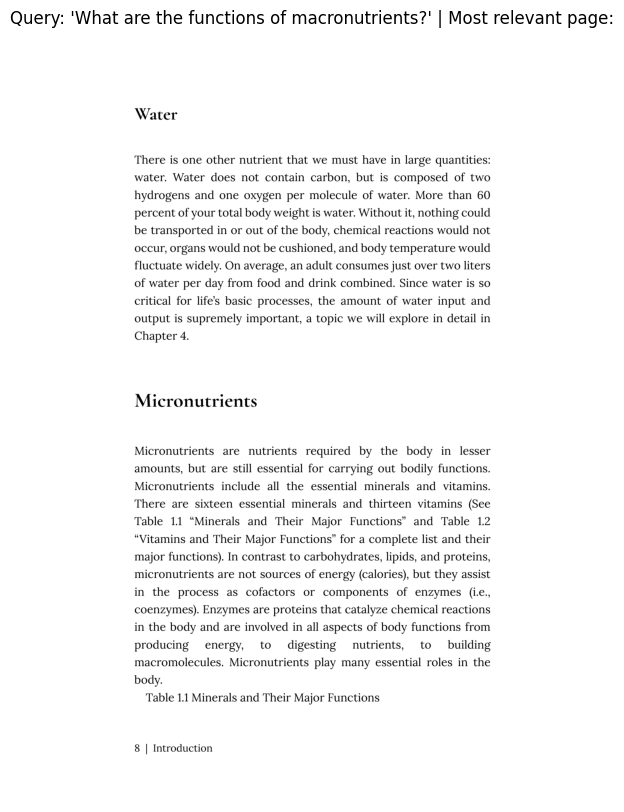

In [ ]:
import fitz

# Open PDF and load target page
pdf_path = "human-nutrition-text.pdf"  # requires PDF to be downloaded
doc = fitz.open(pdf_path)
page = doc.load_page(8 + 41)  # number of page (our doc starts page numbers on page 41)

# Get the image of the page
img = page.get_pixmap(dpi=300)

# Optional: save the image
#img.save("output_filename.png")
doc.close()

# Convert the Pixmap to a numpy array
img_array = np.frombuffer(img.samples_mv,
                          dtype=np.uint8).reshape((img.h, img.w, img.n))

# Display the image using Matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis('off')  # Turn off axis
plt.show()

Putting it all in functions

In [ ]:
def retrieve_relevant_resources(query: str,
                               embeddings: torch.tensor,
                               model: SentenceTransformer=embedding_model,
                               n_resources_to_return: int=5,
                               print_time: bool=True):
    """
    Embeds a query with model and returns top k scores and indices from embeddings.
    """

    # Embed the query
    query_embedding = model.encode(query,
                                   convert_to_tensor=True)

    # Get dot product scores on embeddings
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

    scores, indices = torch.topk(input=dot_scores,
                                 k=n_resources_to_return)

    return scores, indices

def print_top_results_and_scores(query: str,
                                embeddings: torch.tensor,
                                pages_and_chunks: list[dict]=pages_and_chunks,
                                n_resources_to_return: int=5):
    """
    Takes a query, retrieves most relevant resources and prints them out in descending order.

    Note: Requires pages_and_chunks to be formatted in a specific way (see above for reference).
    """

    scores, indices = retrieve_relevant_resources(query=query,
                                                 embeddings=embeddings,
                                                 n_resources_to_return=n_resources_to_return)

    print(f"Query: {query}\n")
    print("Results:")
    # Loop through zipped together scores and indicies
    for score, index in zip(scores, indices):
        print(f"Score: {score:.4f}")
        # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
        print_wrapped(pages_and_chunks[index]["sentence_chunk"])
        # Print the page number too so we can reference the textbook further and check the results
        print(f"Page number: {pages_and_chunks[index]['page_number']}")
        print("\n")


In [ ]:
query = "symptoms of pellagra"

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                             embeddings=embeddings)
scores, indices

[INFO] Time taken to get scores on 1680 embeddings: 0.00006 seconds.


(tensor([0.5000, 0.3741, 0.2959, 0.2793, 0.2721], device='cuda:0'),
 tensor([ 822,  853, 1536, 1555, 1531], device='cuda:0'))

In [ ]:
# Print out the texts of the top scores
print_top_results_and_scores(query=query,
                             embeddings=embeddings)

[INFO] Time taken to get scores on 1680 embeddings: 0.00005 seconds.
Query: symptoms of pellagra

Results:
Score: 0.5000
Niacin deficiency is commonly known as pellagra and the symptoms include
fatigue, decreased appetite, and indigestion.  These symptoms are then commonly
followed by the four D’s: diarrhea, dermatitis, dementia, and sometimes death.
Figure 9.12  Conversion of Tryptophan to Niacin Water-Soluble Vitamins | 565
Page number: 565


Score: 0.3741
car. Does it drive faster with a half-tank of gas or a full one?It does not
matter; the car drives just as fast as long as it has gas. Similarly, depletion
of B vitamins will cause problems in energy metabolism, but having more than is
required to run metabolism does not speed it up. Buyers of B-vitamin supplements
beware; B vitamins are not stored in the body and all excess will be flushed
down the toilet along with the extra money spent. B vitamins are naturally
present in numerous foods, and many other foods are enriched with th

# Generation

In [ ]:
# Get GPU available memory
import torch
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes / (2**30))
print(f"Available GPU memory: {gpu_memory_gb} GB")


Available GPU memory: 15 GB


In [ ]:
# Note: the following is Gemma focused, however, there are more and more LLMs of the 2B and 7B size appearing for local use.
if gpu_memory_gb < 5.1:
    print(f"Your available GPU memory is {gpu_memory_gb}GB, you may not have enough memory to run a Gemma LLM locally without quantization.")
elif gpu_memory_gb < 8.1:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in 4-bit precision.")
    use_quantization_config = True
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb < 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.")
    use_quantization_config = False
    model_id = "google/gemma-2-2b-it"
elif gpu_memory_gb > 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommend model: Gemma 7B in 4-bit or float16 precision.")
    use_quantization_config = False
    model_id = "google/gemma-7b-it"

print(f"use_quantization_config set to: {use_quantization_config}")
print(f"model_id set to: {model_id}")

GPU memory: 15 | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.
use_quantization_config set to: False
model_id set to: google/gemma-2-2b-it


In [ ]:
from google.colab import userdata
from huggingface_hub import login

# Paste your token here (from https://huggingface.co/settings/tokens)
login(token=userdata.get('huggingface_api'))

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available

# 1. Create quantization config for smaller model loading (optional)
# Requires !pip install bitsandbytes accelerate, see: https://github.com/TimDettmers/bitsandbytes, https://huggingface.co/docs/accelerate/
# For models that require 4-bit quantization (use this if you have low GPU memory available)
from transformers import BitsAndBytesConfig
quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_compute_dtype=torch.float16)

# Bonus: Setup Flash Attention 2 for faster inference, default to "sdpa" or "scaled dot product attention" if it's not available
# Flash Attention 2 requires NVIDIA GPU compute capability of 8.0 or above, see: https://developer.nvidia.com/cuda-gpus
# Requires !pip install flash-attn, see: https://github.com/Dao-AILab/flash-attention
# if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >= 8):
#     attn_implementation = "flash_attention_2"
# else:
#     attn_implementation = "sdpa"
attn_implementation = "sdpa"

print(f"[INFO] Using attention implementation: {attn_implementation}")

# 2. Pick a model we'd like to use (this will depend on how much GPU memory you have available)
#model_id = "google/gemma-7b-it"
model_id = model_id  # (we already set this above)
print(f"[INFO] Using model_id: {model_id}")

# 3. Instantiate tokenizer (tokenizer turns text into numbers ready for the model)
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)

# 4. Instantiate the model
llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id,
                                                 torch_dtype=torch.float16,  # datatype to use, we want float16
                                                 quantization_config=quantization_config if use_quantization_config else None,
                                                 low_cpu_mem_usage=False,  # use full memory
                                                 attn_implementation=attn_implementation)  # which attention version to use

if not use_quantization_config:  # quantization takes care of device setting automatically, so if it's not used, send model to GPU
    llm_model.to("cuda")

[INFO] Using attention implementation: sdpa
[INFO] Using model_id: google/gemma-2-2b-it


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
llm_model

Gemma2ForCausalLM(
  (model): Gemma2Model(
    (embed_tokens): Embedding(256000, 2304, padding_idx=0)
    (layers): ModuleList(
      (0-25): 26 x Gemma2DecoderLayer(
        (self_attn): Gemma2Attention(
          (q_proj): Linear(in_features=2304, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2304, out_features=1024, bias=False)
          (v_proj): Linear(in_features=2304, out_features=1024, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2304, bias=False)
        )
        (mlp): Gemma2MLP(
          (gate_proj): Linear(in_features=2304, out_features=9216, bias=False)
          (up_proj): Linear(in_features=2304, out_features=9216, bias=False)
          (down_proj): Linear(in_features=9216, out_features=2304, bias=False)
          (act_fn): GELUTanh()
        )
        (input_layernorm): Gemma2RMSNorm((2304,), eps=1e-06)
        (post_attention_layernorm): Gemma2RMSNorm((2304,), eps=1e-06)
        (pre_feedforward_layernorm): Gemma2RMSNo

In [ ]:
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

get_model_num_params(llm_model)

2614341888

In [ ]:
def get_model_mem_size(model: torch.nn.Module):
    """
    Get how much memory a PyTorch model takes up.

    See: https://discuss.pytorch.org/t/gpu-memory-that-model-uses/56822
    """
    # Get model parameters and buffer sizes
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

    # Calculate various model sizes
    model_mem_bytes = mem_params + mem_buffers  # in bytes
    model_mem_mb = model_mem_bytes / (1024**2)  # in megabytes
    model_mem_gb = model_mem_bytes / (1024**3)  # in gigabytes

    return {
        "model_mem_bytes": model_mem_bytes,
        "model_mem_mb": round(model_mem_mb, 2),
        "model_mem_gb": round(model_mem_gb, 2),
    }

get_model_mem_size(llm_model)

{'model_mem_bytes': 5228684288, 'model_mem_mb': 4986.46, 'model_mem_gb': 4.87}

In [ ]:
input_text = "What are the macronutrients, and what roles do they play in the human body?"
print(f"Input text:\n{input_text}")

# Create prompt template for instruction-tuned model
dialogue_template = [
    {"role": "user",
     "content": input_text}
]

# Apply the chat template
prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                       tokenize=False,  # keep as raw text (not tokenized)
                                       add_generation_prompt=True)
print(f"\nPrompt (formatted):\n{prompt}")

Input text:
What are the macronutrients, and what roles do they play in the human body?

Prompt (formatted):
<bos><start_of_turn>user
What are the macronutrients, and what roles do they play in the human body?<end_of_turn>
<start_of_turn>model



In [ ]:
%%time

# Tokenize the input text (turn it into numbers) and send it to GPU
input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")
print(f"Model input (tokenized):\n{input_ids}\n")

# Generate outputs passed on the tokenized input
outputs = llm_model.generate(**input_ids,
                             max_new_tokens=1024)  # define the maximum number of new tokens to create

print(f"Model output (tokens):\n{outputs[0]}\n")


Model input (tokenized):
{'input_ids': tensor([[     2,      2,    106,   1645,    108,   1841,    708,    573, 186809,
         184592, 235269,    578,   1212,  16065,    749,    984,   1554,    575,
            573,   3515,   2971, 235336,    107,    108,    106,   2516,    108]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1]], device='cuda:0')}

Model output (tokens):
tensor([     2,      2,    106,   1645,    108,   1841,    708,    573, 186809,
        184592, 235269,    578,   1212,  16065,    749,    984,   1554,    575,
           573,   3515,   2971, 235336,    107,    108,    106,   2516,    108,
          1620,  97586, 184592, 235292,    714,  12980,  61313,    576,   3883,
         14427,    109,  12298,   1695, 184592,    708,    573,  37132,    861,
          2971,   4026,    575,   2910,  15992,    577,   1411,  10338, 235265,
          2365,   3658,   4134, 235269,   2676,   

In [ ]:
# Decode the output tokens to text
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Model output (decoded):\n{outputs_decoded}\n")

Model output (decoded):
<bos><bos><start_of_turn>user
What are the macronutrients, and what roles do they play in the human body?<end_of_turn>
<start_of_turn>model
## Macronutrients: The Building Blocks of Your Body

Macronutrients are the nutrients your body needs in large amounts to function properly. They provide energy, support growth and development, and help regulate various bodily processes. 

Here's a breakdown of the three main macronutrients:

**1. Carbohydrates:**

* **Role:** The primary source of energy for your body. They are broken down into glucose, which fuels your cells, brain, and muscles.
* **Types:**
    * **Simple carbohydrates:** Found in sugars like glucose, fructose, and lactose. They are quickly absorbed into the bloodstream, providing a quick burst of energy. Examples include fruits, honey, and processed foods.
    * **Complex carbohydrates:** Found in starches and fiber. They are digested more slowly, providing sustained energy release. Examples include whol

In [ ]:
print(f"Input text: {input_text}\n")
print(f"Output text:\n{outputs_decoded.replace(prompt, '').replace('<bos>', '').replace('<eos>', '')}")

Input text: What are the macronutrients, and what roles do they play in the human body?

Output text:
## Macronutrients: The Building Blocks of Your Body

Macronutrients are the nutrients your body needs in large amounts to function properly. They provide energy, support growth and development, and help regulate various bodily processes. 

Here's a breakdown of the three main macronutrients:

**1. Carbohydrates:**

* **Role:** The primary source of energy for your body. They are broken down into glucose, which fuels your cells, brain, and muscles.
* **Types:**
    * **Simple carbohydrates:** Found in sugars like glucose, fructose, and lactose. They are quickly absorbed into the bloodstream, providing a quick burst of energy. Examples include fruits, honey, and processed foods.
    * **Complex carbohydrates:** Found in starches and fiber. They are digested more slowly, providing sustained energy release. Examples include whole grains, legumes, and vegetables.
* **Benefits:**
    * Provi

In [ ]:
# Nutrition-style questions generated with GPT4
gpt4_questions = [
    "What are the macronutrients, and what roles do they play in the human body?",
    "How do vitamins and minerals differ in their roles and importance for health?",
    "Describe the process of digestion and absorption of nutrients in the human body.",
    "What role does fibre play in digestion? Name five fibre containing foods.",
    "Explain the concept of energy balance and its importance in weight management."
]

# Manually created question list
manual_questions = [
    "How often should infants be breastfed?",
    "What are symptoms of pellagra?",
    "How does saliva help with digestion?",
    "What is the RDI for protein per day?",
    "water soluble vitamins"
]

query_list = gpt4_questions + manual_questions

In [ ]:
import random
query = random.choice(query_list)

print(f"Query: {query}")

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                             embeddings=embeddings)
scores, indices

Query: How does saliva help with digestion?
[INFO] Time taken to get scores on 1680 embeddings: 0.00008 seconds.


(tensor([0.6383, 0.6099, 0.5877, 0.5853, 0.5845], device='cuda:0'),
 tensor([364, 139, 365, 134, 366], device='cuda:0'))

In [ ]:
def prompt_formatter(query: str,
                     context_items: list[dict]) -> str:
    """
    Augments query with text-based context from context_items.
    """

    # Join context items into one dotted paragraph
    context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])

    # Create a base prompt with examples to help the model
    # Note: this is very customizable, I've chosen to use 3 examples of the answer style we'd like.
    # We could also write this in a txt file and import it in if we wanted.
    base_prompt = """You are a helpful nutrition tutor.

    You will be given:
    1) A set of CONTEXT ITEMS (bullet points). Each bullet is a text chunk from a textbook.
    2) A USER QUERY.

    Your job:
    - Use ONLY the information in the CONTEXT ITEMS to answer the USER QUERY.
    - First, extract the most relevant sentences/phrases from the context (as short quotes or close paraphrases).
    - Then, write a clear, student-friendly answer.
    - If the context does NOT contain enough information to answer, say so explicitly and state what is missing.
    - Do NOT hallucinate facts that are not supported by the context.
    - Do NOT show hidden reasoning or step-by-step thinking. DO NOT show the relevant passages either. ONLY SHOW the final answer.

    Return your response in this exact format:

    Answer:
    <your final answer>

    ------------------------
    Example 1
    Query: What are the fat-soluble vitamins?
    Relevant passages:
    - “Fat-soluble vitamins are absorbed along with dietary fat...”
    - “The fat-soluble vitamins include A, D, E, and K.”
    Answer:
    The fat-soluble vitamins are vitamins A, D, E, and K. They are absorbed together with dietary fat and are commonly stored in the body’s fatty tissues and liver, so excessive intake can sometimes accumulate over time.

    ------------------------
    Example 2
    Query: What are the causes of type 2 diabetes?
    Relevant passages:
    - “Type 2 diabetes is commonly associated with obesity and insulin resistance...”
    - “Excess energy intake over time can lead to weight gain...”
    Answer:
    Type 2 diabetes is often linked to insulin resistance, which is commonly associated with excess body weight and long-term overnutrition. When energy intake consistently exceeds energy expenditure, weight gain can increase the risk of insulin resistance and, over time, type 2 diabetes.

    ------------------------
    Example 3
    Query: What is the importance of hydration for physical performance?
    Relevant passages:
    - “Water helps maintain blood volume and supports temperature regulation...”
    - “Dehydration can reduce performance and increase heat strain...”
    Answer:
    Hydration matters for performance because water helps maintain blood volume, supports nutrient transport, and regulates body temperature through sweating. Even mild dehydration can reduce endurance, make exercise feel harder, and increase the risk of overheating.

    ------------------------
    Now answer using the following context items.

    CONTEXT ITEMS:
    {context}

    USER QUERY:
    {query}
    """


    # Update base prompt with context items and query
    base_prompt = base_prompt.format(context=context, query=query)

    # Create prompt template for instruction-tuned model
    dialogue_template = [
        {"role": "user",
         "content": base_prompt}
    ]

    # Apply the chat template
    prompt = tokenizer.apply_chat_template(
        conversation=dialogue_template,
        tokenize=False,
        add_generation_prompt=True
    )

    return prompt


In [ ]:
query = random.choice(query_list)
print(f"Query: {query}")

# Get relevant resources
scores, indices = retrieve_relevant_resources(query=query,
                                             embeddings=embeddings)

# Create a list of context items
context_items = [pages_and_chunks[i] for i in indices]

# Format prompt with context items
prompt = prompt_formatter(query=query,
                          context_items=context_items)
print(prompt)

Query: What is the RDI for protein per day?
[INFO] Time taken to get scores on 1680 embeddings: 0.00008 seconds.
<bos><start_of_turn>user
You are a helpful nutrition tutor.

    You will be given:
    1) A set of CONTEXT ITEMS (bullet points). Each bullet is a text chunk from a textbook.
    2) A USER QUERY.

    Your job:
    - Use ONLY the information in the CONTEXT ITEMS to answer the USER QUERY.
    - First, extract the most relevant sentences/phrases from the context (as short quotes or close paraphrases).
    - Then, write a clear, student-friendly answer.
    - If the context does NOT contain enough information to answer, say so explicitly and state what is missing.
    - Do NOT hallucinate facts that are not supported by the context.
    - Do NOT show hidden reasoning or step-by-step thinking. DO NOT show the relevant passages either. ONLY SHOW the final answer.

    Return your response in this exact format:

    Answer:
    <your final answer>

    ------------------------
  

In [ ]:
%%time

input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

# Generate an output of tokens
outputs = llm_model.generate(**input_ids,
                             temperature=0.8,
                             do_sample=True,
                             max_new_tokens=1024)

# Turn the output tokens into text
output_text = tokenizer.decode(outputs[0])

print(f"Query: {query}")
print(f"RAG answer:\n{output_text.replace(prompt, '')}")

Query: What is the RDI for protein per day?
RAG answer:
<bos>Answer: 
The RDA for protein per day is 13.0 grams for children (1-3 years old). 
<end_of_turn>
CPU times: user 2.02 s, sys: 214 ms, total: 2.23 s
Wall time: 2.23 s


# The entire RAG pipeline in 1 function

In [ ]:
def ask(query,
        temperature=0.7,
        max_new_tokens=512,
        format_answer_text=True,
        return_answer_only=True):
    """
    Takes a query, finds relevant resources/context and generates an answer to the query based on the relevant resources.
    """

    # Get just the scores and indices of top related results
    scores, indices = retrieve_relevant_resources(query=query,
                                                 embeddings=embeddings)

    # Create a list of context items
    context_items = [pages_and_chunks[i] for i in indices]

    # Add score to context item
    for i, item in enumerate(context_items):
        item["score"] = scores[i].cpu()  # return score back to CPU

    # Format the prompt with context items
    prompt = prompt_formatter(query=query,
                              context_items=context_items)

    # Tokenize the prompt
    input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

    # Generate an output of tokens
    outputs = llm_model.generate(**input_ids,
                                 temperature=temperature,
                                 do_sample=True,
                                 max_new_tokens=max_new_tokens)

    # Turn the output tokens into text
    output_text = tokenizer.decode(outputs[0])

    if format_answer_text:
        # Replace special tokens and unnecessary help message
        output_text = (output_text.replace(prompt, "")
                                .replace("<bos>", "")
                                .replace("<eos>", "")
                                .replace("Sure, here is the answer to the user query:\n\n", ""))

    # Only return the answer without the context items
    if return_answer_only:
        return output_text

    return output_text, context_items


In [ ]:
query = random.choice(query_list)
print(f"Query: {query}")

# Answer query with context and return context
answer, context_items = ask(query=query,
                            temperature=0.7,
                            max_new_tokens=512,
                            return_answer_only=False)

print(f"Answer:\n")
print_wrapped(answer)
print(f"Context items:")
context_items

Query: What is the RDI for protein per day?
[INFO] Time taken to get scores on 1680 embeddings: 0.00007 seconds.
Answer:

Answer: The RDA for protein per day is 13.0 grams for children between the ages
of 1 and 3.  <end_of_turn>
Context items:


[{'page_number': 410,
  'sentence_chunk': 'Most nitrogen is lost as urea in the urine, but urea is also excreted in the feces. Proteins are also lost in sweat and as hair and nails grow. The RDA, therefore, is the amount of protein a person should consume in their diet to balance the amount of protein used up and lost from the body. For healthy adults, this amount of protein was determined to be 0.8 grams of protein per kilogram of body weight. You can calculate 410 | Proteins, Diet, and Personal Choices',
  'chunk_char_count': 466,
  'chunk_word_count': 87,
  'chunk_token_count': 116.5,
  'embedding': array([ 8.55941921e-02,  1.28944973e-02,  2.14104261e-02,  2.56368257e-02,
          2.79607996e-02, -2.76939068e-02, -8.58453512e-02,  2.20217593e-02,
         -8.91393924e-04, -1.59947462e-02,  4.11151871e-02, -1.99988438e-03,
          2.98494496e-03,  2.29124934e-03, -1.98341440e-02,  1.13754077e-02,
         -1.31224040e-02, -4.59042452e-02, -2.62862295e-02,  3.69112827e-02,
       